### EXP: Heat map all experts raters

In [1861]:
import os
import pandas as pd
import numpy as np
import json
import itertools
import seaborn as sns
from sklearn import metrics
from matplotlib import gridspec as gs
import matplotlib.pyplot as plt
from functools import reduce

In [1862]:
%matplotlib inline
%load_ext rpy2.ipython
sns.set(style="white")

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [1863]:
def CustomParser(data):
    j1 = json.loads(data)
    return j1

In [1864]:
# Read raw table
classifications = pd.read_csv('../data/rating/brain-match-classifications-12-10-2018.csv', 
                              converters={'metadata':CustomParser,
                                          'annotations':CustomParser,
                                          'subject_data':CustomParser},
                              header=0)

In [1865]:
# List all workflows 
classifications.workflow_name.unique()

array(['Spot anatomical differences', 'Spot functional differences',
       'anat_internal_rating_pierre', 'anat_internal_rating_yassine',
       'Training Session', 'Basile', 'Benjamin', 'Maxime', 'Angela',
       'Sara', 'Pierre_func_rate_1', 'Pierre_anat_rate1',
       'Yassine_func_rate_1', 'Pierre_func_rate_2', 'Start Project',
       'Start Project 1', 'Expert Project 1', 'Expert Project 2',
       'Start Project 2'], dtype=object)

In [1866]:
# Get 3 experts from full launch workflow
ratings_sp1 =  classifications.loc[classifications['workflow_name'].isin(['Start Project 1'])]
ratings_sp1 = ratings_sp1[ratings_sp1.user_name.isin([ 'colezweber','ppf'])]
# Get rating from first expert workflow
ratings_ep1 = classifications.loc[classifications['workflow_name'].isin(['Expert Project 1'])]
ratings_ep1 = ratings_ep1[ratings_ep1.user_name.isin(['angelatam', 'jenichen', 'ppf','abadhwar'])]
ratings = ratings_sp1.append(ratings_ep1)
# Get rating from second expert workflow
ratings_ep2 = classifications.loc[classifications['workflow_name'].isin(['Expert Project 2'])]
ratings = ratings.append(ratings_ep2)
ratings.count()

classification_id    1247
user_name            1247
user_id              1247
user_ip              1247
workflow_id          1247
workflow_name        1247
workflow_version     1247
created_at           1247
gold_standard           0
expert                  0
metadata             1247
annotations          1247
subject_data         1247
subject_ids          1247
dtype: int64

In [1867]:
# extract tagging count
ratings.loc[:,"n_tagging"] = [ len(q[0]['value']) for q in ratings.annotations]
# extract rating count
ratings.loc[:,"rating"] = [ q[1]['value'] for q in ratings.annotations]
# extract subjects id
ratings.loc[:,"ID"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['subject_ID'] for ind,row in ratings.iterrows()]
# extract files name
ratings.loc[:,"imgnm"] = [ row.subject_data[str(ratings.subject_ids.loc[ind])]['image1'] for ind,row in ratings.iterrows()]

In [1868]:
# Remove non-experts
ratings = ratings[~ratings.user_name.isin(['crocodoyle',
                                           'alinanaseer',
                                           'EloiPrevost',
                                           'venguix',
                                           'ashherr17'])]

In [1869]:
# How many rating per user
user_count = ratings.user_name.value_counts()
user_count

ppf           213
colezweber    149
surchs        105
paulej        102
emdupre       102
cmakowski     102
angelatam     101
jenichen      100
abadhwar      100
Name: user_name, dtype: int64

In [1870]:
#select only users that have rated a certain ammount of images 
list_user = user_count.index
list_user = list_user[user_count.values>=10]
user_count[list_user]

ppf           213
colezweber    149
surchs        105
paulej        102
emdupre       102
cmakowski     102
angelatam     101
jenichen      100
abadhwar      100
Name: user_name, dtype: int64

In [1871]:
# remove users with less rating then the selected threshold
ratings = ratings[ratings.user_name.isin(list_user)]
ratings.count()

classification_id    1074
user_name            1074
user_id              1074
user_ip              1074
workflow_id          1074
workflow_name        1074
workflow_version     1074
created_at           1074
gold_standard           0
expert                  0
metadata             1074
annotations          1074
subject_data         1074
subject_ids          1074
n_tagging            1074
rating               1074
ID                   1074
imgnm                1074
dtype: int64

In [1872]:
# drop duplicated rating
inc = 0
sum_dup = 0
for ind,user in enumerate(ratings.user_name.unique()):
    user_select_df = ratings[ratings.user_name.isin([user])]
    mask=~user_select_df.ID.duplicated()
    dup = len([m for m in mask if m == False])
    sum_dup = sum_dup+ dup
    if dup > 0 :
        print('{} have {} duplicated ratings'.format(user,dup))
    if ind == 0 and inc == 0:
        classi_unique= user_select_df[mask]
        inc+=1
    else:
        classi_unique = classi_unique.append(user_select_df[~user_select_df.ID.duplicated()])
        inc+=1
print('Total number of duplicated ratings  = {}'.format(sum_dup))

colezweber have 49 duplicated ratings
ppf have 113 duplicated ratings
angelatam have 1 duplicated ratings
surchs have 5 duplicated ratings
emdupre have 2 duplicated ratings
cmakowski have 2 duplicated ratings
paulej have 2 duplicated ratings
Total number of duplicated ratings  = 174


In [1873]:
# Get the final rating numbers per subject
user_count = classi_unique.user_name.value_counts()
user_count

jenichen      100
paulej        100
emdupre       100
ppf           100
cmakowski     100
surchs        100
abadhwar      100
angelatam     100
colezweber    100
Name: user_name, dtype: int64

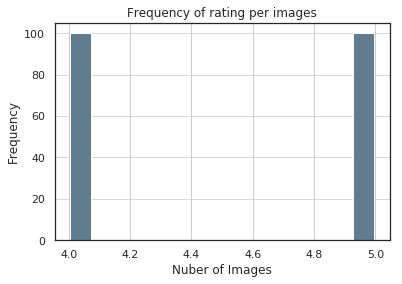

In [1874]:
# plot rating per image distribution
image_count = classi_unique.subject_ids.value_counts()
image_count.plot.hist(grid=True,rwidth=0.9, bins=13,color='#607c8e')
plt.title('Frequency of rating per images')
plt.xlabel('Nuber of Images')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [1875]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,jenichen,paulej,emdupre,ppf,cmakowski,surchs,abadhwar,angelatam,colezweber
0,X0010051,Maybe,OK,Maybe,OK,OK,OK,OK,OK,OK
1,X2571197,OK,OK,OK,OK,OK,OK,OK,OK,OK
2,X2014113,OK,OK,Maybe,OK,OK,OK,OK,OK,Maybe
3,X0010120,Maybe,Maybe,OK,OK,Maybe,Maybe,OK,Maybe,Maybe
4,X0010009,OK,OK,Maybe,OK,Fail,OK,Maybe,Maybe,OK


In [1876]:
#Create Users rating dataframe
list_user = user_count.index
concat_rating = [classi_unique[classi_unique.user_name == user][['ID','rating']].rename(columns={'rating': user})
                  for user in list_user]

df_ratings = reduce(lambda left,right: pd.merge(left,right,how='outer',on='ID'), concat_rating)
df_ratings.head()

,ID,jenichen,paulej,emdupre,ppf,cmakowski,surchs,abadhwar,angelatam,colezweber
0,X0010051,Maybe,OK,Maybe,OK,OK,OK,OK,OK,OK
1,X2571197,OK,OK,OK,OK,OK,OK,OK,OK,OK
2,X2014113,OK,OK,Maybe,OK,OK,OK,OK,OK,Maybe
3,X0010120,Maybe,Maybe,OK,OK,Maybe,Maybe,OK,Maybe,Maybe
4,X0010009,OK,OK,Maybe,OK,Fail,OK,Maybe,Maybe,OK


In [1877]:
# remove duplicates
df_ratings = df_ratings[~df_ratings.ID.duplicated()]

### Explore the concensus of rating between images

In [1878]:
# Get ratings from images rated more tan N different rates 
n = 4 # Minimun number of ratings per image
stuff = np.array([[row.ID,
                   np.sum(row[1:].values=='Fail'),
                   np.sum(row[1:].values=='Maybe'),
                   np.sum(row[1:].values=='OK')]  
                  for ind, row in df_ratings.iterrows() if np.sum([np.sum(row[1:-1].values=='Fail'),
                                                                 np.sum(row[1:-1].values=='Maybe'),
                                                                 np.sum(row[1:-1].values=='OK')]) >= n])
df_score = pd.DataFrame(data=stuff, columns=['ID','Fail', 'Maybe', 'OK'])
df_score.head()

,ID,Fail,Maybe,OK
0,X0010051,0,2,7
1,X2571197,0,0,9
2,X2014113,0,2,7
3,X0010120,0,6,3
4,X0010009,1,3,5


In [1879]:
# Normalise table's row
df_score_tmp = df_score[['Fail','Maybe','OK']].astype('int')
nb_rating = df_score[['Fail','Maybe','OK']].astype('int').sum(axis="columns")
df_norm = pd.DataFrame( index=df_score.index,columns=['ID','Fail', 'Maybe', 'OK'])
for status in ['Fail','Maybe','OK']:
    for image in df_score.index:
        df_norm[status][image] = np.int(df_score[status][image])/nb_rating[image]
        df_norm['ID'][image] = df_score['ID'][image]
# get max value
max_value = [row.iloc[1:].get_values().max() for ind,row in df_norm.iterrows()]
df_norm.loc[:,'EconVal'] = max_value
# get concensus rating
s = ['Fail', 'Maybe', 'OK']
#max_rate = [row.iloc[1:].idxmax(axis=1) for ind,row in df_norm.iterrows()]
max_rate = [s[row[1:].values.argmax()] for rid, row in df_norm.iterrows()]
df_norm.loc[:,'Econ'] = max_rate
# merge with zcon
zcon_df = pd.read_csv('../data/rating/full_launch_zooniverse_consensus.csv')
df_norm = df_norm.merge(zcon_df,on= 'ID')
df_norm.head()

,ID,Fail,Maybe,OK,EconVal,Econ,ZconVal,Zcon
0,X0010051,0,0.222222,0.777778,0.777778,OK,0.454545,Fail
1,X2571197,0,0,1,1.000000,OK,0.565217,OK
2,X2014113,0,0.222222,0.777778,0.777778,OK,0.727273,OK
3,X0010120,0,0.666667,0.333333,0.666667,Maybe,0.687500,OK
4,X0010009,0.111111,0.333333,0.555556,0.555556,OK,0.523810,OK


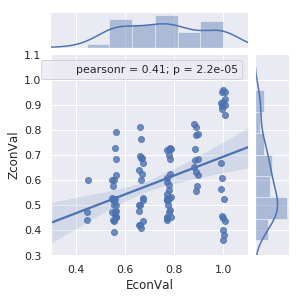

In [1880]:
import scipy.stats as stats
sns.set(color_codes=True)
joint = sns.jointplot(x='EconVal', y='ZconVal',data= df_norm,
              kind="reg",xlim=[0.3,1.1], ylim=[0.3,1.1],x_jitter=.01)
joint.annotate(stats.pearsonr)

joint.fig.set_figwidth(4)
joint.fig.set_figheight(4)
plt.savefig('../reports/figures/Results/Kappa/expert_vs_zooniv_consensus.svg')

Text(0, 0.5, 'Concensus rating')

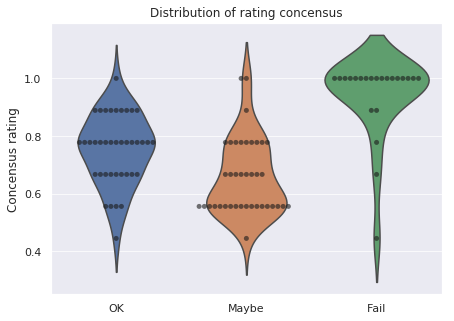

In [1881]:
#Setting the figure with matplotlib
plt.figure(figsize=(7,5))
#plt.xticks(rotation=90)
plt.rcParams["axes.labelsize"] = 12
 
#Creating the desired plot
sns.violinplot(x='Econ',y='EconVal',data=df_norm,
              inner=None #removes the inner bars inside the violins 
              )
 
sns.swarmplot(x='Econ',y='EconVal',data=df_norm,
             color='k',#for making the points black
             alpha=0.6) #value of alpha will increase the transparency
 
#Title for the plot
plt.grid(axis='y', alpha=0.75)
plt.title('Distribution of rating concensus')
plt.xlabel('')
plt.ylabel('Concensus rating')

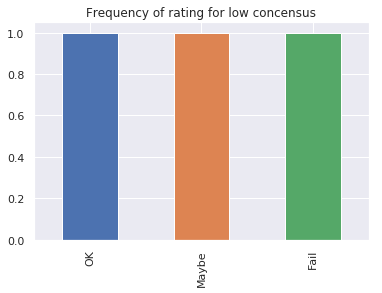

In [1882]:
count_ = df_norm.Econ[[0 <= row.EconVal < 0.5   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for low concensus')

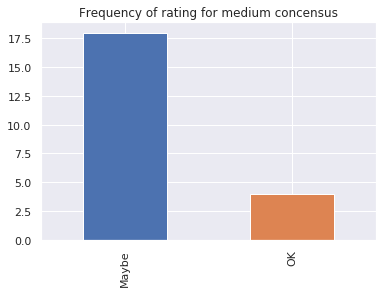

In [1883]:
count_ = df_norm.Econ[[0.5 <= row.EconVal < 0.65   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for medium concensus')

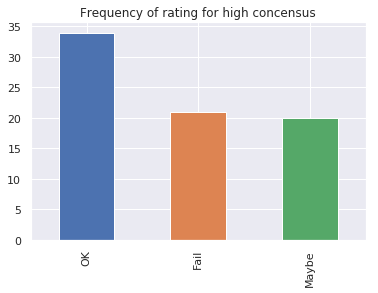

In [1884]:
count_ = df_norm.Econ[[0.6 < row.EconVal <= 1   for ind, row in df_norm.iterrows() ]].value_counts()
axes = count_.plot.bar(title = 'Frequency of rating for high concensus')

In [1885]:
# Save a copy
df_ratings.rename(columns={'angelatam':'R6',
                           'colezweber':'R9',
                           'ppf':'R8',
                           'jenichen':'R7',
                           'abadhwar':'R5',
                           'cmakowski':'R3',
                           'surchs':'R1',
                           'paulej':'R2',
                           'emdupre':'R4'},inplace=True)
df_ratings =df_ratings[['ID',
                        'R1',
                        'R2',
                        'R3',
                        'R4',
                        'R5',
                        'R6',
                        'R7',
                        'R8', 'R9']].merge(df_norm[['ID','Econ','Zcon','EconVal','ZconVal']],on='ID')
df_ratings.to_csv('../data/rating/all_experts_ratings.csv',index=False)
df_ratings.head()

,ID,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon,EconVal,ZconVal
0,X0010051,OK,OK,OK,Maybe,OK,OK,Maybe,OK,OK,OK,Fail,0.777778,0.454545
1,X2571197,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK,1.000000,0.565217
2,X2014113,OK,OK,OK,Maybe,OK,OK,OK,OK,Maybe,OK,OK,0.777778,0.727273
3,X0010120,Maybe,Maybe,Maybe,OK,OK,Maybe,Maybe,OK,Maybe,Maybe,OK,0.666667,0.687500
4,X0010009,OK,OK,Fail,Maybe,Maybe,Maybe,OK,OK,OK,OK,OK,0.555556,0.523810


In [1886]:
# Randomly split raters in three groups
import random
random.seed(0)
myList= ['R1','R2','R3','R4','R5','R6','R7','R8','R9']
raters_split = [[myList.pop(random.randrange(len(myList))) for ii in range(3)] for ll in range(3)]

In [1887]:
# Replace OK with 1 , Maybe with 2 and Fail with 3
df_ratings.replace({'OK':1,'Maybe':2, 'Fail':3}, inplace=True)

df_ratings.head()

,ID,R1,R2,R3,R4,R5,R6,R7,R8,R9,Econ,Zcon,EconVal,ZconVal
0,X0010051,1,1,1,2,1,1,2,1,1,1,3,0.777778,0.454545
1,X2571197,1,1,1,1,1,1,1,1,1,1,1,1.000000,0.565217
2,X2014113,1,1,1,2,1,1,1,1,2,1,1,0.777778,0.727273
3,X0010120,2,2,2,1,1,2,2,1,2,2,1,0.666667,0.687500
4,X0010009,1,1,3,2,2,2,1,1,1,1,1,0.555556,0.523810


### Report tagging from Full lanch 1 raters

In [1905]:
# output markings from classifications
clist=[]
for index, c in classi_unique.iterrows():
    if c['n_tagging'] > 0:
        for q in c.annotations[0]['value']:
            clist.append({'ID':c.ID, 'workflow_name':c.workflow_name,'user_name':c.user_name, 'rating':c.rating,'imgnm':c.imgnm, 
                          'x':q['x'], 'y':np.round(q['y']).astype(int), 'r':'1.5','n_tagging':c.n_tagging ,'frame':q['frame']})
    else:
        clist.append({'ID':c.ID, 'workflow_name':c.workflow_name, 'user_name':c.user_name,'rating':c.rating,'imgnm':c.imgnm, 
                          'x':float('nan'), 'y':float('nan'), 'r':float('nan'),'n_tagging':c.n_tagging ,'frame':'1'})

col_order=['ID','workflow_name','user_name','rating','x','y','r','n_tagging','imgnm','frame']
out_tag = pd.DataFrame(clist)[col_order]
out_tag.head()

,ID,workflow_name,user_name,rating,x,y,r,n_tagging,imgnm,frame
0,X0010038,Start Project 1,colezweber,Maybe,88.659973,189.0,1.5,3,X_0010038_anat.png,0
1,X0010038,Start Project 1,colezweber,Maybe,512.719971,652.0,1.5,3,X_0010038_anat.png,0
2,X0010038,Start Project 1,colezweber,Maybe,542.689941,652.0,1.5,3,X_0010038_anat.png,1
3,X0010083,Start Project 1,colezweber,Maybe,88.500000,191.0,1.5,1,X_0010083_anat.png,0
4,X0010088,Start Project 1,colezweber,OK,NaN,NaN,NaN,0,X_0010088_anat.png,1


In [1906]:
# Extract unique IDs for each image
ids_imgnm = np.reshape([out_tag.ID.unique(),out_tag.imgnm.unique()],(2,np.shape(out_tag.ID.unique())[0]))
df_ids_imgnm = pd.DataFrame(np.sort(ids_imgnm.T, axis=0),columns=['ID', 'imgnm'])
df_ids_imgnm = df_ids_imgnm.merge(df_norm[['ID','EconVal','Econ']], on='ID')
df_ids_imgnm.head()

,ID,imgnm,EconVal,Econ
0,HC0040038,HC0040038_anat.png,0.555556,OK
1,HC0040043,HC0040043_anat.png,0.777778,OK
2,HC0040045,HC0040045_anat.png,0.777778,OK
3,HC0040048,HC0040048_anat.png,0.555556,Maybe
4,HC0040050,HC0040050_anat.png,0.666667,OK


In [1907]:
#raters accronym
rater_dict = {'angelatam':'R6',
            'colezweber':'R9',
            'ppf':'R8',
            'jenichen':'R7',
            'abadhwar':'R5',
            'cmakowski':'R3',
            'surchs':'R1',
            'paulej':'R2',
            'emdupre':'R4'}

In [1908]:
# Populate patches
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row_.ID,row_.user_name,row_.rating,
                     row_.x,row_.y,row_.n_tagging,
                     row.EconVal,row.Econ) for ind,row_ in out_tmp.iterrows()])
patches_raw = patches

patches = [x for x in sum(patches,[]) if str(x[3]) != 'nan']
patches_df = pd.DataFrame(patches, columns=['ID','user_name','rating','x','y','n_tagging','cons','rate'])
patches_df.replace({'user_name':rater_dict},inplace=True)
display(patches_df.head())

patches_raw = [x for x in sum(patches_raw,[])]
patches_raw_df = pd.DataFrame(patches_raw, columns=['ID','user_name','rating','x','y','n_tagging','cons','rate'])
patches_raw_df.replace({'user_name':rater_dict},inplace=True)
display(patches_raw_df.head())

,ID,user_name,rating,x,y,n_tagging,cons,rate
0,HC0040038,R7,Maybe,113.200073,301.0,2,0.555556,OK
1,HC0040038,R7,Maybe,79.160622,599.0,2,0.555556,OK
2,HC0040038,R5,Maybe,87.633331,192.0,1,0.555556,OK
3,HC0040038,R4,Maybe,86.468750,600.0,2,0.555556,OK
4,HC0040038,R4,Maybe,316.468750,302.0,2,0.555556,OK


,ID,user_name,rating,x,y,n_tagging,cons,rate
0,HC0040038,R9,OK,NaN,NaN,0,0.555556,OK
1,HC0040038,R8,OK,NaN,NaN,0,0.555556,OK
2,HC0040038,R6,OK,NaN,NaN,0,0.555556,OK
3,HC0040038,R7,Maybe,113.200073,301.0,2,0.555556,OK
4,HC0040038,R7,Maybe,79.160622,599.0,2,0.555556,OK


In [1909]:
# Create custom color map
from matplotlib.colors import LinearSegmentedColormap , ListedColormap
from PIL import Image
def _cmap_from_image_path(img_path):
        img = Image.open(img_path)
        img = img.resize((256, img.height))
        colours = (img.getpixel((x, 0)) for x in range(256))
        colours = [(r/255, g/255, b/255, a/255) for (r, g, b, a) in colours]
        return colours,LinearSegmentedColormap.from_list('from_image', colours)

    
coll,a=_cmap_from_image_path('../data/Misc/custom_ColBar.png')
#invert color map
coll_r = ListedColormap(coll[::-1])

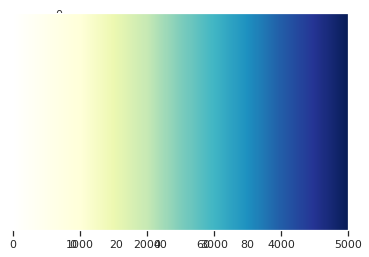

In [1893]:
#attempt to  create a color map that is transparent at the lower end
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set upper part: 4 * 256/4 entries
upper = mpl.cm.YlGnBu(np.arange(256))

# set lower part: 1 * 256/4 entries
# - initialize all entries to 1 to make sure that the alpha channel (4th column) is 1
lower = np.ones((int(256/4),4))
# - modify the first three columns (RGB):
#   range linearly between white (1,1,1) and the first color of the upper colormap
for i in range(3):
    lower[:,i] = np.linspace(1, upper[0,i], lower.shape[0])

# combine parts of colormap
cmap = np.vstack(( lower, upper ))

# convert to matplotlib colormap
cmap = mpl.colors.ListedColormap(cmap, name='myColorMap', N=cmap.shape[0])
# open a new figure
fig, ax = plt.subplots()

# some data to plot: distance to point at (50,50)
x,y = np.meshgrid(np.linspace(0,99,100),np.linspace(0,99,100))
z   = (x-50)**2. + (y-50)**2.

# plot data, apply colormap, set limit such that our interpretation is correct
im = ax.imshow(z, interpolation='nearest', cmap=cmap, clim=(0,5000))

# add a colorbar to the bottom of the image
div  = make_axes_locatable(ax)
cax  = div.append_axes('bottom', size='5%', pad=0.4)
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')

# save/show the image



### Plot heat map for all tagging

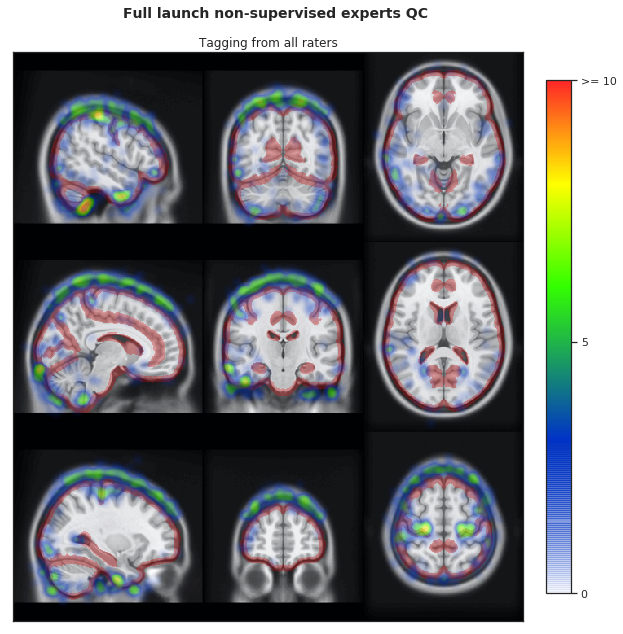

In [1910]:
from heatmappy import Heatmapper
from PIL import Image
sns.set(style="white")
patches=list()
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = out_tag[out_tag['ID'] == row.ID]
    patches.append([(row.x,row.y) for ind,row in out_tmp.iterrows()])

patches = [x for x in sum(patches,[]) if str(x[0]) != 'nan']

# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch non-supervised experts QC',x=0.49,y=.83, fontsize=14, fontweight='bold')

img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from all raters')

heatmapper = Heatmapper(opacity=0.5,
                        point_diameter=20,
                        point_strength = 0.1,
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patches, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '5', '>= 10'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Results/Heat_maps/Full_launch1_all-experts-heatmap_tags.svg')

## heatmap high consensus

In [1916]:
# set threshold and rating
rate_val = 'Fail'
cons_thr = 0.6
thr_sign = 'h'

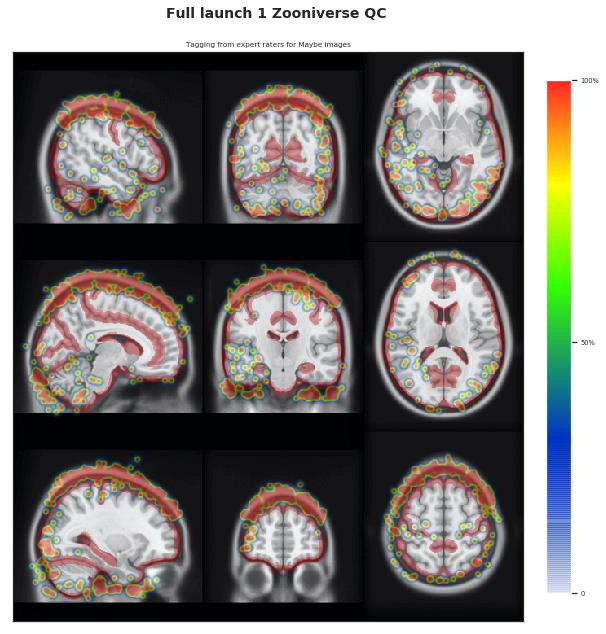

In [1917]:
from heatmappy import Heatmapper
from PIL import Image
sns.set(style="white")
# plot heat map on the template
f, axes = plt.subplots(1, 1,figsize = (10,14))
f.subplots_adjust(hspace= .8)
f.suptitle('Full launch 1 Zooniverse QC',x=0.49,y=.83, fontsize=14, fontweight='bold')
sns.set(font_scale=0.6)
img = Image.open('../data/Misc/template_stereotaxic_v3.png')
axes.set_title('Tagging from expert raters for Maybe images')

# set color different for each rater
list_tagger = out_tmp.user_name.unique()
list_tagger.sort()

if thr_sign == 'h':
    out_tmp = patches_df.loc[(patches_df["rate"] == rate_val) &
                            (patches_df["cons"] > cons_thr), :]
elif thr_sign == 'l':
    out_tmp = patches_df.loc[(patches_df["rate"] == rate_val) &
                            (patches_df["cons"] < cons_thr), :]
else:
    raise Exception('thr_sign should be either ''h'' or ''l''. The value of thr_sign was: {}'.format(thr_sign))


tag_ = np.zeros((len(out_tmp.ID.unique()),len(list_tagger)))
for i_id, v_id in enumerate (out_tmp.ID.unique()):
    out_ = out_tmp[out_tmp['ID'] == v_id]
    tag_[i_id,:] = [sum(out_[out_['user_name'] == rater].n_tagging.unique()) for rater in list_tagger]
# tagging weight   
norm1 = tag_/ np.linalg.norm(tag_)
tt =[norm1[i,:].sum() for i in range(len(norm1))]

#select specific patches
if thr_sign == 'h':
    patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == rate_val and rr.cons > cons_thr ]
elif thr_sign == 'l':
    patch_ = [(rr.x,rr.y)  for ii,rr in patches_df.iterrows() if rr.rate == rate_val and rr.cons < cons_thr ]
else:
    raise Exception('thr_sign should be either ''h'' or ''l''. The value of thr_sign was: {}'.format(thr_sign))

heatmapper = Heatmapper(opacity=0.4,
                        point_diameter=15,
                        point_strength =1/np.max(tt),
                        colours=a)
heatmap= heatmapper.heatmap_on_img(patch_, img)

im = axes.imshow(heatmap,cmap=coll_r)
axes.set_yticklabels([])
axes.set_xticklabels([])

cbar = plt.colorbar(im, orientation='vertical', ticks=[0, 125, 255],fraction=0.046, pad=0.04,ax=axes)
cbar.ax.set_yticklabels(['0', '50%', '100%'])

img.close()
heatmap.close()
f.savefig('../reports/figures/Results/Heat_maps/Experts_{}_cons_{}_{}.svg'.format(rate_val,str(cons_thr),thr_sign))

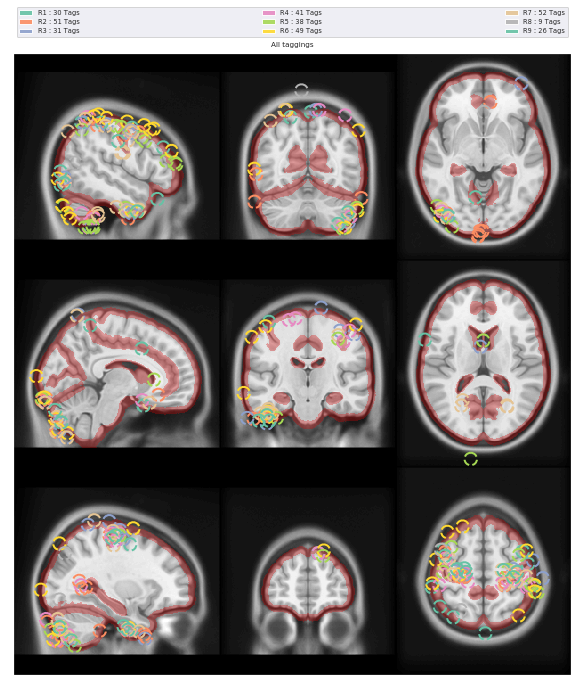

In [1904]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Arrow

#Set Template image as background
fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot(111)
im = plt.imread('../data/Misc/template_stereotaxic_v3.png')
ax.set_title('All taggings')
ax.imshow(im)
#fig.suptitle('Pilot2 QC',x=0.51,y=.87, fontsize=14, fontweight='bold')
# Plot tags
sns.set(font_scale=0.6)

if thr_sign == 'h':
    out_tmp = patches_raw_df.loc[(patches_raw_df["rate"] == rate_val) &
                                 (patches_raw_df["cons"] > cons_thr), :]
elif thr_sign == 'l':
    out_tmp = patches_raw_df.loc[(patches_raw_df["rate"] == rate_val) &
                                 (patches_raw_df["cons"] < cons_thr), :]
else:
    raise Exception('thr_sign should be either ''h'' or ''l''. The value of thr_sign was: {}'.format(thr_sign))


# set color different for each rater
list_tagger = out_tmp.user_name.unique()
list_tagger.sort()
colors_tagger = sns.color_palette("Set2", len(list_tagger))

for idx,tagger in enumerate(list_tagger):
    out_tagger = out_tmp[out_tmp['user_name'] == tagger]
    c = [Circle((rowtag.x,rowtag.y), 7) 
         for itag,rowtag in out_tagger.iterrows()]
    p =  PatchCollection(c,facecolor='none', 
                        edgecolor=colors_tagger[idx], 
                        alpha=1,
                        linewidth=2,
                        linestyle='dashed')
    ax.add_collection(p)


#Set figure Tags labels       
tag_ = np.zeros((len(out_tmp.ID.unique()),len(list_tagger)))
l = list()
labels = list()
for i_id, v_id in enumerate (out_tmp.ID.unique()):
    out_ = out_tmp[out_tmp['ID'] == v_id]
    tag_[i_id,:]= [sum(out_[out_['user_name'] == rater].n_tagging.unique()) for rater in list_tagger]

for rater_id, rater in enumerate(list_tagger):
    l.append(Circle((None,None), facecolor=colors_tagger[rater_id], alpha=0.9))
    labels.append('{} : {:g} Tags'.format(rater,tag_.sum(axis=0)[rater_id]))
        
ax.legend(handles=l,labels=labels, 
          bbox_to_anchor=(0., 1.02, 1., .2), 
          mode='expand', ncol=3, loc="lower right")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.grid(False)
img.close()

fig.savefig('../reports/figures/Results/Heat_maps/Experts_tag_{}_cons_{}_{}.svg'.format(rate_val,str(cons_thr),thr_sign))

[]

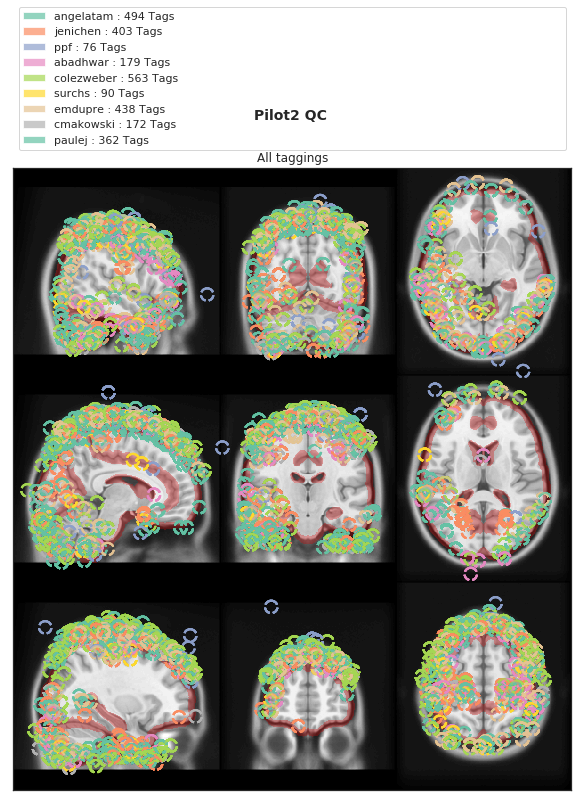

In [546]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle, Arrow

#Set Template image as background
fig = plt.figure(figsize=(10,14))
ax = fig.add_subplot(111)
im = plt.imread('../data/Misc/template_stereotaxic_v3.png')
ax.set_title('All taggings')
ax.imshow(im)
fig.suptitle('Pilot2 QC',x=0.51,y=.87, fontsize=14, fontweight='bold')
# Plot tags
for ind, row in df_ids_imgnm.iterrows():
    out_tmp = patches_raw_df[patches_raw_df['ID'] == row.ID and patches_raw_df['rate'] == 'OK' 
                             and patches_raw_df['cons'] < 0.6 ]
    patches = []
    labels = []
    for ind,row in out_tmp.iterrows():
        for idx,tagger in enumerate(list_tagger):
            out_tagger = out_tmp[out_tmp['user_name'] == tagger]
            c = [Circle((rowtag.x,rowtag.y), 7) 
                 for itag,rowtag in out_tagger.iterrows()]
            p =  PatchCollection(c,facecolor='none', 
                                edgecolor=colors_tagger[idx], 
                                alpha=0.4,
                                linewidth=2,
                                linestyle='dashed')
            ax.add_collection(p)
            
    #Set figure Tags labels       
    tag_ = np.zeros((len(df_ids_imgnm),len(list_tagger)))
    l = list()
    labels = list()
    for ind, row in df_ids_imgnm.iterrows():
        out_tmp = out_tag[out_tag['ID'] == row.ID]
        patches = []
        labels = []
        tag_[ind,:]= [sum(out_tmp[out_tmp['user_name'] == rater].n_tagging.unique()) 
                         for rater in list_tagger]

    for rater_id, rater in enumerate(list_tagger):
        l.append(Circle((None,None), facecolor=colors_tagger[rater_id], alpha=0.7))
        labels.append('{} : {:g} Tags'.format(rater,tag_.sum(axis=0)[rater_id]))
        
ax.legend(handles=l,labels=labels, 
          bbox_to_anchor=(0., 1.02, 1., .2), 
          mode='expand', ncol=1, loc="lower right")
ax.set_xticklabels([])
ax.set_yticklabels([])
#fig.savefig('../reports/figures/pilot2_qc_tags.svg')

In [145]:
import numpy as np
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
# Random data
data1 = np.random.random((4,4))

# Choose colormap
cmap = plt.cm.viridis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

# Create new colormap
my_cmap = ListedColormap(my_cmap)

In [143]:
cmap = plt.cm.viridis

# Get the colormap colors
my_cmap = cmap(np.arange(cmap.N))

# Set alpha
my_cmap[:,-1] = np.linspace(0, 1, cmap.N)

In [144]:
aa= LinearSegmentedColormap.from_list('from_image', my_cmap)

In [139]:
my_cmap

array([[0.993248  , 0.906157  , 0.143936  , 0.        ],
       [0.983868  , 0.904867  , 0.136897  , 0.00392157],
       [0.974417  , 0.90359   , 0.130215  , 0.00784314],
       ...,
       [0.269944  , 0.014625  , 0.341379  , 0.99215686],
       [0.26851   , 0.009605  , 0.335427  , 0.99607843],
       [0.267004  , 0.004874  , 0.329415  , 1.        ]])